In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st
import matplotlib.pyplot as plt
from gapfill_utilities import utils as gf_utils
from statsmodels.stats.proportion import proportions_ztest
import sys
sys.path.append('/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/src/')
import utils as lm_utils

In [2]:
expected_mutations = pd.read_csv('../../MPN_expected_mutations.csv')[['sample','name','mutation_freq']]
expected_mutations.rename(columns={'mutation_freq': 'expected_frequency_from_bulk'}, inplace=True)

## manually fix some that were annotated wrong/incompletely
expected_mutations.loc[expected_mutations['name'] == 'JAK2 c.3187_3189','name'] = 'JAK2 c.3188G>A'
expected_mutations.loc[expected_mutations['name'] == 'CALR c.1154_1155insTTGTC','name'] = 'CALR c.1155_1156insTTGTC' ### this is incorrect - the right mutation is found but for some reason HGVSc comes out off by one
expected_mutations.loc[expected_mutations['name'] == 'ASXL1 c.2245_2246insGG','name'] = 'ASXL1 c.2246_2247insGG' ### the function should handle this, but it doesn't in this case so this is quick fix
expected_mutations.loc[expected_mutations['name'] == 'TET2 c.3218G>A','name'] = 'TET2 c.3218A>G' ### check if this is actually right

expected_mutations = pd.concat([
    expected_mutations,
    pd.DataFrame([{
        'sample': 'BC007_1',
        'name': 'NRAS c.35G>A',
        'expected_frequency_from_bulk': 0,
        'HGVSc': 'c.35G>A',
        'gene': 'NRAS'
    }])
], ignore_index=True)

expected_mutations['HGVSc'] = expected_mutations['name'].str.split(' ').str[1]
expected_mutations['gene'] = expected_mutations['name'].str.split(' ').str[0]

expected_mutations = pd.concat([
    expected_mutations,
    pd.DataFrame([{
        'sample': 'BC001_1plex',
        'name': 'JAK2 c.1849G>T',
        'expected_frequency_from_bulk': 0.8,
        'HGVSc': 'c.1849G>T',
        'gene': 'JAK2'
    }])
], ignore_index=True)

all_expected_mutations = expected_mutations.copy()



In [3]:
def make_merge_table(directory, label_control_column = False, lib = ''):
    BCs = []
    merge_columns = ['gapfill', 'gapfill_from_transcriptome','gapfill_start','gap_probe_sequence','likelihood_given_wt_edit_dist','lhs_probe','rhs_probe']
    # Read all tables in the directory
    i = 0
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        return pd.DataFrame()  # Return an empty DataFrame if directory doesn't exist
    else:
        for file in os.listdir(directory):
            if file.endswith('.csv'):  # Assuming the tables are in CSV format
                table_name = os.path.splitext(file)[0].split('gapfills_')[1]
                BCs.append(table_name)
                current_table = pd.read_csv(os.path.join(directory, file))
                current_table.rename(columns={'likelihood': 'likelihood_given_wt_edit_dist'}, inplace=True)

                ### add empty gap_probe_sequence rows even for gapfills that were not found
                subset_table = current_table.drop_duplicates(subset=['lhs_probe','rhs_probe','gap_probe_sequence']).dropna(subset=['gap_probe_sequence'])
                subset_table.loc[:,'gapfill'] = subset_table['gap_probe_sequence'].copy()
                subset_table.loc[:,'likelihood_given_wt_edit_dist'] = 0
                subset_table.loc[:,'frequency'] = 0
                subset_table.loc[:,'count_of_this_gapfill'] = 0
                current_table = pd.concat([current_table, subset_table]).drop_duplicates(subset=['lhs_probe','rhs_probe','gapfill'])

                columns_to_rename = [col for col in current_table.columns if col not in merge_columns]
                current_table.rename(columns={col: col + '_' + table_name for col in columns_to_rename}, inplace=True)
                if i == 0:
                    merged_table = current_table
                else:
                    merged_table = merged_table.merge(
                    current_table,
                    on=merge_columns,
                    how='outer'
                    )
                i += 1

        merged_table.loc[:,merged_table.columns.str.contains('count_of_this_gapfill')] = merged_table.loc[:,merged_table.columns.str.contains('count_of_this_gapfill')].fillna(0)
        merged_table.loc[:,merged_table.columns.str.contains('frequency')] = merged_table.loc[:,merged_table.columns.str.contains('frequency')].fillna(0)
        
        if label_control_column:
            if lib != '':
                merged_table = label_control_columns(merged_table,lib)

        ## rename columns with lib as suffix
        merged_table = merged_table.rename(
            columns={col: col + '_' + lib for col in merged_table.columns if col not in merge_columns}
        )
        merged_table['gapfill'] = merged_table['gapfill'].fillna('')
        merged_table['gapfill_from_transcriptome'] = merged_table['gapfill_from_transcriptome'].fillna('')
        return merged_table

def label_control_columns(merged_table, lib):
    patient_key = pd.read_csv('/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/MPN_patient_coverage_by_panel.csv')

    # Drop rows where either '16-plex 1' or 'patient_id' is missing
    mapping_df = patient_key[['16-plex ' + lib, 'patient_id']].dropna()
    mapping_df.rename(columns={'16-plex ' + lib: 'BC'}, inplace=True)

    # Extract integer from '16-plex 1' (e.g., 'BC003' -> 3)
    mapping_df['bc_int'] = mapping_df['BC'].str.split('BC0').str[1].astype(int)

    control_idx = mapping_df.loc[mapping_df['patient_id'] == 'control PBMC','bc_int'].values[0]
    control_gapfill_count_column = 'count_of_this_gapfill_BC0' + str(control_idx)
    control_probe_count_column = 'count_of_this_probe_BC0' + str(control_idx)
    if control_gapfill_count_column not in merged_table.columns:
        print(f"Warning: {control_gapfill_count_column} not found in merged_table columns.")
    else:
        merged_table['count_of_this_gapfill_control'] = merged_table[control_gapfill_count_column]
        merged_table['count_of_this_probe_control'] = merged_table[control_probe_count_column]
    return merged_table

def sum_probe_counts(merged_table):
    libs = merged_table.columns.str.split('count_of_this_gapfill_').str[1].dropna().unique()
    ### now add total probe counts for gapfills that were not present in that sample
    for BC in libs:
        gapfill_col = f'count_of_this_gapfill_{BC}'
        probe_col = f'count_of_this_probe_{BC}'
        if gapfill_col in merged_table.columns and probe_col in merged_table.columns:
            summed = merged_table.groupby(['lhs_probe','rhs_probe','gapfill_from_transcriptome'])[gapfill_col].transform('sum')
            merged_table[probe_col] = summed
            # merged_table[probe_col] = merged_table[probe_col].fillna(summed).infer_objects(copy=False)
    return merged_table

def name_variants_by_gapfill(merged_long,expected_mutations,merge_columns):
    if 'HGVSc' in merged_long.columns:
        merged_long = merged_long.drop(columns=['HGVSc'])
    merged_long['hgvs_change'] = merged_long.apply(
        lambda row: lm_utils.get_hgvs_from_gapfill(
            str(row['gapfill_from_transcriptome']) if pd.notnull(row['gapfill_from_transcriptome']) else '',
            str(row['gapfill']) if pd.notnull(row['gapfill']) else '',
            int(row['gapfill_start']) if (pd.notnull(row['gapfill_start']) and ',' not in row['gapfill_start']) else '',
            return_all=True, revcomp = True
        ),
        axis=1
    )
    merged_long['HGVSc'] = merged_long.apply(lambda row: lm_utils.extract_matching_hgvs(row, expected_mutations), axis=1)
    merged_long = merged_long.drop(['hgvs_change'],axis=1)
    print('len merged long',len(merged_long))
    merged_long['HGVSc'] = merged_long['HGVSc'].str.replace('c.=_novel','wildtype')
    print('len merged long after merge',len(merged_long))
    return merged_long

In [4]:
merged_table_1 = make_merge_table('unexpected_gapfill_likelihoods_1', label_control_column=True, lib='1')
merged_table_2 = make_merge_table('unexpected_gapfill_likelihoods_2', label_control_column=True, lib='2')
merged_table_4plex = make_merge_table('unexpected_gapfill_likelihoods_4plex', label_control_column=False, lib='4plex')
merged_table_1plex = make_merge_table('unexpected_gapfill_likelihoods_1plex', label_control_column=False, lib='1plex')

In [5]:
merge_columns = ['gapfill', 'gapfill_from_transcriptome','gapfill_start','gap_probe_sequence','likelihood_given_wt_edit_dist','lhs_probe','rhs_probe']

# Merge only if the DataFrames are not empty
if not merged_table_2.empty:
    merged_table = merged_table_1.merge(merged_table_2, on=merge_columns, how='outer')
else:
    merged_table = merged_table_1.copy()

if not merged_table_4plex.empty:
    merged_table = merged_table.merge(merged_table_4plex, on=merge_columns, how='outer')

if not merged_table_1plex.empty:
    merged_table = merged_table.merge(merged_table_1plex, on=merge_columns, how='outer')
    
### manual fix for dual probes
merged_table.loc[(merged_table['lhs_probe'] == 'ATTTAGAGGATAAGGCGGCAGTAGT') & (merged_table['rhs_probe'] == 'TGTGTTCGCTGTAGATCTGACGTAC'),'rhs_probe'] = 'TGTGTTCGCTGTAGATCTGACGTAC/TGTGTAAGGCGGCAGTAGTTGTGTT'
merged_table.loc[(merged_table['lhs_probe'] == 'ATTTAGAGGATAAGGCGGCAGTAGT') & (merged_table['rhs_probe'] == 'TGTGTAAGGCGGCAGTAGTTGTGTT'),'rhs_probe'] = 'TGTGTTCGCTGTAGATCTGACGTAC/TGTGTAAGGCGGCAGTAGTTGTGTT'
merged_table.loc[(merged_table['rhs_probe'] == 'AATAGCTCATTAAAGTCATCTACCG') & (merged_table['lhs_probe'] == 'GCTGGCTGTCAGCGGGTACCTTGCC'),'lhs_probe'] = 'GCTGGCTGTCAGCGGGTACCTTGCC/GCTCTCTGTCAGCGGGTACCTTGCC'
merged_table.loc[(merged_table['rhs_probe'] == 'AATAGCTCATTAAAGTCATCTACCG') & (merged_table['lhs_probe'] == 'GCTCTCTGTCAGCGGGTACCTTGCC'),'lhs_probe'] = 'GCTGGCTGTCAGCGGGTACCTTGCC/GCTCTCTGTCAGCGGGTACCTTGCC'


merged_table = sum_probe_counts(merged_table)


In [6]:
id_vars = list(merge_columns) + list(merged_table.columns[merged_table.columns.str.contains('control')])
value_vars = merged_table.columns.drop(id_vars)

samples = value_vars.str.split('probe_idx_').str[1].dropna().unique()
print('samples to parse:', samples)

dfs = []
for sample in samples:
    df_tmp = merged_table[id_vars].copy()
    for col in value_vars:
        if sample in col:
            df_tmp[col.replace('_' + sample, '')] = merged_table[col]
    df_tmp['sample'] = sample
    dfs.append(df_tmp)

merged_long = pd.concat(dfs, ignore_index=True)


merged_long['original_name'] = merged_long['name'].copy()
### manual fix for extra added probes
merged_long['name'] = merged_long['name'].str.replace('_extra','')
### manual fix for TET2 c.3218G>A
merged_long.loc[merged_long['name'] == 'TET2 c.3218G>A','gapfill_start'] = '3217'

## drop rows where name is NaN or gapfill count is 0
# merged_long = merged_long.loc[(merged_long['name'].notna()) & (merged_long['count_of_this_gapfill'].notna()) & (merged_long['count_of_this_gapfill'] > 0)]

## drop rows where probe_idx is NaN
merged_long = merged_long.loc[merged_long['probe_idx'].notna()]

### add HGVSc based on observed gapfill
merged_long = name_variants_by_gapfill(merged_long, all_expected_mutations, merge_columns)

## reorder columns for better interpretability
cols = ['name','HGVSc'] + merge_columns + [col for col in merged_long.columns if col not in (['name','HGVSc'] + merge_columns)]
merged_long = merged_long[cols]

## manual fix for dual probes
merged_long.loc[(merged_long['name'] == 'ASXL1 c.2081_2099dup_0') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].isna()),'HGVSc'] = 'ASXL1 c.2081_2099dup'
merged_long.loc[(merged_long['name'] == 'ASXL1 c.2081_2099dup_1') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].notna()),'HGVSc'] = 'ASXL1 wildtype'
merged_long.loc[(merged_long['name'] == 'ASXL1 c.2081_2099dup_0') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].isna()),'name'] = 'ASXL1 c.2081_2099dup'
merged_long.loc[(merged_long['name'] == 'ASXL1 c.2081_2099dup_1') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].notna()),'name'] = 'ASXL1 c.2081_2099dup'

merged_long.loc[(merged_long['name'] == 'NFE2 c.782_785del_0') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].isna()),'HGVSc'] = 'NFE2 c.782_785del'
merged_long.loc[(merged_long['name'] == 'NFE2 c.782_785del_1') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].notna()),'HGVSc'] = 'NFE2 wildtype'
merged_long.loc[(merged_long['name'] == 'NFE2 c.782_785del_0') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].isna()),'name'] = 'NFE2 c.782_785del'
merged_long.loc[(merged_long['name'] == 'NFE2 c.782_785del_1') & (merged_long['gapfill'] == '') & (merged_long['gapfill_start'].notna()),'name'] = 'NFE2 c.782_785del'
##

merged_long['frequency'] = merged_long['count_of_this_gapfill'] / merged_long['count_of_this_probe']


samples to parse: Index(['BC012_1', 'BC010_1', 'BC002_1', 'BC007_1', 'BC014_1', 'BC008_1',
       'BC004_1', 'BC015_1', 'BC005_1', 'BC016_1', 'BC009_1', 'BC013_1',
       'BC003_1', 'BC001_1', 'BC006_1', 'BC011_1', 'BC005_2', 'BC016_2',
       'BC010_2', 'BC004_2', 'BC001_2', 'BC012_2', 'BC009_2', 'BC008_2',
       'BC015_2', 'BC002_2', 'BC007_2', 'BC013_2', 'BC006_2', 'BC011_2',
       'BC014_2', 'BC003_2', 'BC003_4plex', 'BC004_4plex', 'BC002_4plex',
       'BC001_4plex', 'BC001_1plex'],
      dtype='object')
len merged long 47272
len merged long after merge 47272


In [7]:
### manually add splice variants
### this could be done from the spreadsheet; could be before mapping HGVSc and the wildtype would be assigned correctly (but splice variant HGVSc must be done after)

merged_long.loc[(merged_long['name'] == 'TP53 c.920-1G>A'),'gapfill_from_transcriptome'] = 'GCT'
merged_long.loc[(merged_long['name'] == 'TP53 c.920-1G>A') & (merged_long['gapfill'] == 'GCT'),'HGVSc'] = 'TP53 wildtype'
merged_long.loc[(merged_long['name'] == 'TP53 c.920-1G>A') & (merged_long['gapfill'] == 'GTT'),'HGVSc'] = 'TP53 c.920-1G>A'

merged_long.loc[(merged_long['name'] == 'TET2 c.4537+2T>G'),'gapfill_from_transcriptome'] = 'TTACC'
merged_long.loc[(merged_long['name'] == 'TET2 c.4537+2T>G') & (merged_long['gapfill'] == 'TTACC'),'HGVSc'] = 'TET2 wildtype'
merged_long.loc[(merged_long['name'] == 'TET2 c.4537+2T>G') & (merged_long['gapfill'] == 'TAACC'),'HGVSc'] = 'TET2 c.4537+3A>T'
merged_long.loc[(merged_long['name'] == 'TET2 c.4537+2T>G') & (merged_long['gapfill'] == 'TTCCC'),'HGVSc'] = 'TET2 c.4537+2T>G'

merged_long.loc[(merged_long['name'] == 'TP53 c.376-2A>G'),'gapfill_from_transcriptome'] = 'CTG'
merged_long.loc[(merged_long['name'] == 'TP53 c.376-2A>G') & (merged_long['gapfill'] == 'CTG'),'HGVSc'] = 'TP53 wildtype'
merged_long.loc[(merged_long['name'] == 'TP53 c.376-2A>G') & (merged_long['gapfill'] == 'CCG'),'HGVSc'] = 'TP53 c.376-2A>G'

merged_long.loc[(merged_long['name'] == 'NFE2 c.115-1G>A'),'gapfill_from_transcriptome'] = 'CCT'
merged_long.loc[(merged_long['name'] == 'NFE2 c.115-1G>A') & (merged_long['gapfill'] == 'CCT'),'HGVSc'] = 'NFE2 wildtype'
merged_long.loc[(merged_long['name'] == 'NFE2 c.115-1G>A') & (merged_long['gapfill'] == 'CTT'),'HGVSc'] = 'NFE2 c.115-1G>A'


In [8]:
total = 0
splice_variant = 0
probe_included = 0
for mutation in all_expected_mutations['name'].unique():
    if mutation not in merged_long['HGVSc'].unique():
        if '+' in mutation or '-' in mutation:
            splice_variant += 1 ### keep these in expected mutations because they were actually targeted
            print(mutation)
        elif len(merged_long.loc[merged_long['name'] == mutation]) > 0:
            if len(merged_long.loc[(merged_long['name'] == mutation) & (merged_long['gapfill'] == merged_long['gap_probe_sequence'])]) > 0:
                print(mutation, ' should be found')
            probe_included += 1 ### keep these in expected mutations because they were actually targeted
            print('included:', mutation)
        else:
            print(mutation)
            expected_mutations = expected_mutations.loc[expected_mutations['name'] != mutation]
        total += 1
        
print(f"Splice variants not found: {splice_variant}")
print(f"Probes included in gapfill: {probe_included}")
print(f"Total mutations not included in gapfill: {total}")

## TP53 c.721T>C, ASXL1 c.1900_1922del not targeted
## SH2B3 c.926G>A looks like it is a different mutation in BC009_2


TP53 c.721T>C
ASXL1 c.1900_1922del
Splice variants not found: 0
Probes included in gapfill: 0
Total mutations not included in gapfill: 2


In [9]:
def get_likelihood_given_edit_distance(merged_long):
    df = merged_long.copy()
    ## aggregate counts across control samples
    df['expected_gapfill_count'] = df['likelihood_given_wt_edit_dist'] * df['count_of_this_probe']
    # Run proportions_ztest for each row
    df['likelihood_observed_proportion_given_edit_dist'] = df.apply(
        lambda row: 1.0 if (
            row['count_of_this_gapfill'] == row['count_of_this_probe'] and
            row['expected_gapfill_count'] == row['count_of_this_probe']  ## p is high because proportions are the same in sample and control
        ) else (
            proportions_ztest(
                [row['count_of_this_gapfill'], row['expected_gapfill_count']],
                [row['count_of_this_probe'], row['count_of_this_probe']]
            )[1] if row['count_of_this_probe'] > 0 and row['expected_gapfill_count'] > 0 else np.nan
        ),
        axis=1
    )
    df['proportion_greater_than_expected_from_edit_dist'] = np.where(df['expected_gapfill_count'] > 0, (df['count_of_this_gapfill'] / df['count_of_this_probe']) > (df['expected_gapfill_count'] / df['count_of_this_probe']), np.nan)
    df['proportion_greater_than_expected_from_edit_dist'] = df['proportion_greater_than_expected_from_edit_dist'].map({1:1, 0:-1, np.nan: np.nan})
    return df.drop(['expected_gapfill_count'], axis=1)

merged_long = get_likelihood_given_edit_distance(merged_long)

In [10]:
def get_likelihood_given_control_sample(merged_long):
    df = merged_long.copy()
    control_probe_count_cols = df.columns[df.columns.str.contains('count_of_this_probe_control_')]
    control_gapfill_count_cols = df.columns[df.columns.str.contains('count_of_this_gapfill_control_')]
    ## aggregate counts across control samples
    df['control_probe_count'] = df[control_probe_count_cols].fillna(0).sum(axis=1)
    df['control_gapfill_count'] = df[control_gapfill_count_cols].fillna(0).sum(axis=1)
    # Run proportions_ztest for each row
    df['likelihood_given_wt_control'] = df.apply(
        lambda row: 1.0 if (
            row['count_of_this_gapfill'] == row['count_of_this_probe'] and
            row['control_gapfill_count'] == row['control_probe_count']  # p is high because proportions are the same in sample and control
        ) else (
            1.0 if (
                row['count_of_this_gapfill'] == 0 and
                row['control_gapfill_count'] == 0
            ) else (
                proportions_ztest(
                    [row['count_of_this_gapfill'], row['control_gapfill_count']],
                    [row['count_of_this_probe'], row['control_probe_count']]
                )[1] if row['count_of_this_probe'] > 0 and row['control_probe_count'] > 0 else np.nan
            )
        ),
        axis=1
    )
    df['proportion_greater_than_expected_from_control'] = np.where(df['control_probe_count'] > 0, (df['count_of_this_gapfill'] / df['count_of_this_probe']) > (df['control_gapfill_count'] / df['control_probe_count']), np.nan)
    df['proportion_greater_than_expected_from_control'] = df['proportion_greater_than_expected_from_control'].map({1:1, 0:-1, np.nan: np.nan})
    return df


merged_long = get_likelihood_given_control_sample(merged_long)

In [11]:
merged_long['gapfill_start'] = merged_long['gapfill_start'].fillna('not_found')
def get_likelihood_given_all_other_samples(merged_long):
    for sample in merged_long['sample'].unique():
        ref = merged_long.copy()
        ref = ref.loc[ref['sample'] != sample].groupby(['gapfill','gapfill_start','lhs_probe','rhs_probe']).agg({
            'count_of_this_gapfill': 'sum'}).reset_index()
        probe_count = merged_long.loc[merged_long['sample'] != sample].drop_duplicates(subset=['sample','lhs_probe','rhs_probe']).groupby(['lhs_probe','rhs_probe']).agg({
            'count_of_this_probe': 'sum'}).reset_index()
        df = merged_long.loc[merged_long['sample'] == sample].merge(ref, on=['gapfill','lhs_probe','rhs_probe','gapfill_start'], how='left', suffixes=('', '_ref'))
        df = df.merge(probe_count, on=['lhs_probe','rhs_probe'], how='left', suffixes=('', '_ref'))
        df['count_of_this_gapfill_ref'] = df['count_of_this_gapfill_ref'].fillna(0)
        df['count_of_this_probe_ref'] = df['count_of_this_probe_ref'].fillna(0)
        # Run proportions_ztest for each row
        df['likelihood_given_other_samples'] = df.apply(
            lambda row: 1.0 if (
            row['count_of_this_gapfill'] == row['count_of_this_probe'] and
            row['count_of_this_gapfill_ref'] == row['count_of_this_probe_ref']  # p is high because proportions are the same in sample and control
            ) else (
            1.0 if (
                row['count_of_this_gapfill'] == 0 and
                row['count_of_this_gapfill_ref'] == 0
            ) else (
                proportions_ztest(
                [row['count_of_this_gapfill'], row['count_of_this_gapfill_ref']],
                [row['count_of_this_probe'], row['count_of_this_probe_ref']]
                )[1] if row['count_of_this_probe'] > 0 and row['count_of_this_probe_ref'] > 0 else np.nan
            )
            ),
            axis=1
        )
        df['proportion_greater_than_expected_from_others'] = np.where(df['count_of_this_probe_ref'] > 0, (df['count_of_this_gapfill'] / df['count_of_this_probe']) > (df['count_of_this_gapfill_ref'] / df['count_of_this_probe_ref']), np.nan)
        df['proportion_greater_than_expected_from_others'] = df['proportion_greater_than_expected_from_others'].map({1:1, 0:-1, np.nan: np.nan})
        concat_df = pd.concat([concat_df, df], ignore_index=True) if 'concat_df' in locals() else df
    merged_long = merged_long.merge(concat_df[['gapfill', 'lhs_probe', 'rhs_probe', 'gapfill_start', 'sample', 'count_of_this_probe_ref','count_of_this_gapfill_ref', 'likelihood_given_other_samples', 'proportion_greater_than_expected_from_others']], on=['gapfill', 'lhs_probe', 'rhs_probe','sample','gapfill_start'], how='left')
    return merged_long

merged_long = get_likelihood_given_all_other_samples(merged_long)


SignificanceResult(statistic=0.19253093518747422, pvalue=1.6035638199150703e-203)
SignificanceResult(statistic=0.7662228115284055, pvalue=0.0)


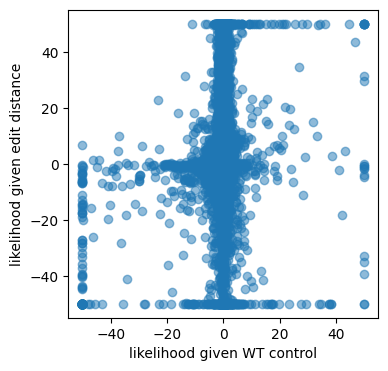

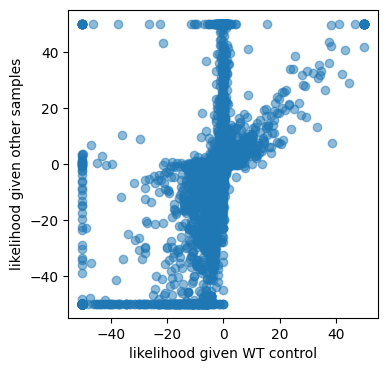

In [12]:
### exploratory - plot likelihoods from ground truth vs likelihoods from edit distance
fig,ax = plt.subplots(figsize=(4,4))
sub_df = merged_long.dropna(subset=['likelihood_given_wt_control','likelihood_observed_proportion_given_edit_dist','proportion_greater_than_expected_from_control','proportion_greater_than_expected_from_edit_dist'])
sub_df = sub_df.loc[sub_df['gapfill'] != sub_df['gapfill_from_transcriptome']]
x = np.log10(sub_df['likelihood_given_wt_control'] + (1e-50))
y = np.log10(sub_df['likelihood_observed_proportion_given_edit_dist'] + (1e-50))
x = x * sub_df['proportion_greater_than_expected_from_control']
y = y * sub_df['proportion_greater_than_expected_from_edit_dist']
ax.scatter(x, y, alpha=0.5)
ax.set_xlabel('likelihood given WT control')
ax.set_ylabel('likelihood given edit distance')
print(st.spearmanr(x,y))

fig,ax = plt.subplots(figsize=(4,4))
sub_df = merged_long.dropna(subset=['likelihood_given_wt_control','likelihood_given_other_samples','proportion_greater_than_expected_from_control','proportion_greater_than_expected_from_others'])
sub_df = sub_df.loc[sub_df['gapfill'] != sub_df['gapfill_from_transcriptome']]
x = np.log10(sub_df['likelihood_given_wt_control'] + (1e-50))
y = np.log10(sub_df['likelihood_given_other_samples'] + (1e-50))
x = x * sub_df['proportion_greater_than_expected_from_control']
y = y * sub_df['proportion_greater_than_expected_from_others']
ax.scatter(x, y, alpha=0.5)
ax.set_xlabel('likelihood given WT control')
ax.set_ylabel('likelihood given other samples')
print(st.spearmanr(x,y))

### the spike of high y values at x=0 are cases in which a mutation is present in another sample so it skews enrichment in this sample


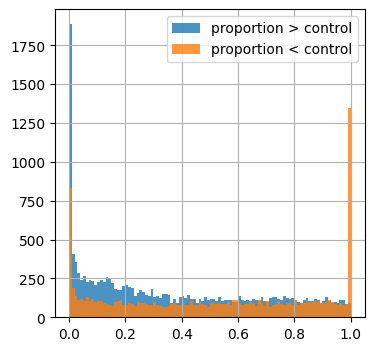

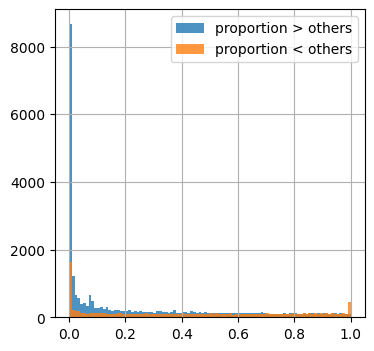

In [13]:
### exploratory - compare p-values for cases of proportion > control (this is what we're interested in) and proportion < control (this shouldn't really happen other than for wt gapfills that become less likely with mutation)

fig,ax = plt.subplots(figsize=(4,4))
merged_long.loc[merged_long['proportion_greater_than_expected_from_control'] == 1].dropna(subset=['likelihood_given_wt_control','likelihood_given_wt_edit_dist'])['likelihood_given_wt_control'].hist(bins=100,ax=ax, label='proportion > control', alpha=0.8)
merged_long.loc[merged_long['proportion_greater_than_expected_from_control'] == -1].dropna(subset=['likelihood_given_wt_control','likelihood_given_wt_edit_dist'])['likelihood_given_wt_control'].hist(bins=100,ax=ax, label='proportion < control', alpha=0.8)
ax.legend()

fig,ax = plt.subplots(figsize=(4,4))
merged_long.loc[merged_long['proportion_greater_than_expected_from_others'] == 1].dropna(subset=['likelihood_given_wt_control','likelihood_given_other_samples'])['likelihood_given_other_samples'].hist(bins=100,ax=ax, label='proportion > others', alpha=0.8)
merged_long.loc[merged_long['proportion_greater_than_expected_from_others'] == -1].dropna(subset=['likelihood_given_wt_control','likelihood_given_other_samples'])['likelihood_given_other_samples'].hist(bins=100,ax=ax, label='proportion < others', alpha=0.8)
ax.legend()

In [14]:
merged_long['signed_log_likelihood_given_wt_control'] = np.log10(merged_long['likelihood_given_wt_control'] + (1e-300)) * merged_long['proportion_greater_than_expected_from_control']
merged_long['signed_log_likelihood_given_other_samples'] = np.log10(merged_long['likelihood_given_other_samples'] + (1e-300)) * merged_long['proportion_greater_than_expected_from_others']
merged_long['signed_log_likelihood_given_wt_edit_dist'] = np.log10(merged_long['likelihood_observed_proportion_given_edit_dist'] + (1e-300)) * merged_long['proportion_greater_than_expected_from_edit_dist']

In [15]:
### check if high background for this CALR mutation
merged_long.loc[(merged_long['name'] == 'CALR c.1150_1154delinsTGTC') & (merged_long['sample'] != 'BC007_1') & ((merged_long['gapfill'] == merged_long['gapfill_from_transcriptome']) | (merged_long['gapfill'] == merged_long['gap_probe_sequence']))][['gapfill','gapfill_from_transcriptome','frequency','gap_probe_sequence','sample','count_of_this_gapfill','count_of_this_probe']].sort_values('count_of_this_gapfill', ascending=False)

,gapfill,gapfill_from_transcriptome,frequency,gap_probe_sequence,sample,count_of_this_gapfill,count_of_this_probe
31175,CTTGTCC,CTTGTCC,0.970599,CGACAC,BC015_2,410405.0,422837.0
9873,CTTGTCC,CTTGTCC,0.971878,CGACAC,BC015_1,374416.0,385250.0
19223,CTTGTCC,CTTGTCC,0.965798,CGACAC,BC006_1,218167.0,225893.0
36033,CTTGTCC,CTTGTCC,0.966590,CGACAC,BC006_2,168030.0,173838.0
6680,CTTGTCC,CTTGTCC,0.970233,CGACAC,BC014_1,19850.0,20459.0
39095,CTTGTCC,CTTGTCC,0.969508,CGACAC,BC014_2,15357.0,15840.0
32958,CTTGTCC,CTTGTCC,0.955294,CGACAC,BC007_2,10214.0,10692.0
18878,CGACAC,CTTGTCC,0.002988,CGACAC,BC006_1,675.0,225893.0
9482,CGACAC,CTTGTCC,0.001630,CGACAC,BC015_1,628.0,385250.0
6566,CGACAC,CTTGTCC,0.003617,CGACAC,BC014_1,74.0,20459.0


In [16]:
merged_long.loc[(merged_long['name'] == 'CALR c.1154_1155insTTGTC') & (merged_long['sample'] != 'BC007_1') & ((merged_long['gapfill'] != merged_long['gapfill_from_transcriptome']))][['gapfill','HGVSc','name','gapfill_from_transcriptome','frequency','gap_probe_sequence','sample','count_of_this_gapfill','count_of_this_probe','gapfill_start']].sort_values('count_of_this_gapfill', ascending=False)

,gapfill,HGVSc,name,gapfill_from_transcriptome,frequency,gap_probe_sequence,sample,count_of_this_gapfill,count_of_this_probe,gapfill_start
17387,CCGACAATT,CALR c.1155_1156insTTGTC,CALR c.1154_1155insTTGTC,CCTT,0.245162,CCTGACAAT,BC001_1,32368.0,132027.0,1153
24765,T,CALR c.1154_1156del_novel,CALR c.1154_1155insTTGTC,CCTT,0.006350,CCTGACAAT,BC016_2,4662.0,734209.0,1153
34772,T,CALR c.1154_1156del_novel,CALR c.1154_1155insTTGTC,CCTT,0.006174,CCTGACAAT,BC013_2,4091.0,662582.0,1153
24239,CTT,CALR c.1156del_novel,CALR c.1154_1155insTTGTC,CCTT,0.004522,CCTGACAAT,BC016_2,3320.0,734209.0,1153
13501,T,CALR c.1154_1156del_novel,CALR c.1154_1155insTTGTC,CCTT,0.006605,CCTGACAAT,BC016_1,3047.0,461321.0,1153
...,...,...,...,...,...,...,...,...,...,...
13930,CCTGACAAT,CALR c.1154_1155insTTGTC_novel,CALR c.1154_1155insTTGTC,CCTT,0.000000,CCTGACAAT,BC009_1,0.0,11885.0,1153
12837,CCTGACAAT,CALR c.1154_1155insTTGTC_novel,CALR c.1154_1155insTTGTC,CCTT,0.000000,CCTGACAAT,BC016_1,0.0,461321.0,1153
46206,CCTGACAAT,CALR c.1154_1155insTTGTC_novel,CALR c.1154_1155insTTGTC,CCTT,0.000000,CCTGACAAT,BC001_4plex,0.0,145950.0,1153
47135,,CALR c.1153_1156del_novel,CALR c.1154_1155insTTGTC,CCTT,NaN,CCTGACAAT,BC001_1plex,0.0,0.0,1153


In [17]:
if 'expected_frequency_from_bulk' not in merged_long.columns:
    merged_long = merged_long.merge(expected_mutations.drop(columns=['HGVSc']).rename(columns={'name': 'HGVSc'}), on=['sample','HGVSc'], how='left')

In [18]:
mutated_df = merged_long.loc[~(merged_long['HGVSc'].fillna('').str.contains('wildtype'))]
print(f"Number of expected mutations included: {len(mutated_df.loc[mutated_df['expected_frequency_from_bulk'].notna()])}")
mutated_df_above_freq = mutated_df.loc[mutated_df['frequency'] > 0.01]
print(f"Number of expected mutations above frequency: {len(mutated_df_above_freq.loc[mutated_df_above_freq['expected_frequency_from_bulk'].notna()])}")

mutated_df_above_count = mutated_df.loc[mutated_df['count_of_this_gapfill'] > 10]
print(f"Number of expected mutations above count: {len(mutated_df_above_count.loc[mutated_df_above_count['expected_frequency_from_bulk'].notna()])}")

mutated_df_above_count_freq = mutated_df_above_count.loc[mutated_df_above_count['frequency'] > 0.01]
print(f"Number of expected mutations above count and frequency: {len(mutated_df_above_count_freq.loc[mutated_df_above_count_freq['expected_frequency_from_bulk'].notna()])}")

Number of expected mutations included: 143
Number of expected mutations above frequency: 121
Number of expected mutations above count: 119
Number of expected mutations above count and frequency: 110


In [19]:
mutated_df.loc[(mutated_df['sample'] == 'BC013_2') & (mutated_df['name'] == 'KRAS c.173C>T')][['count_of_this_gapfill','count_of_this_probe','frequency','HGVSc']].sort_values('frequency', ascending=False)

,count_of_this_gapfill,count_of_this_probe,frequency,HGVSc
34213,180.0,20693.0,0.008699,KRAS c.173C>T
35022,45.0,20693.0,0.002175,KRAS c.175del_novel
35079,18.0,20693.0,0.000870,KRAS c.175G>A_novel
34319,13.0,20693.0,0.000628,KRAS c.173C>A_novel
34776,13.0,20693.0,0.000628,KRAS c.173_175del_novel
33773,7.0,20693.0,0.000338,KRAS c.174A>G_novel
34255,4.0,20693.0,0.000193,KRAS c.172A>G_novel
35047,2.0,20693.0,0.000097,KRAS c.173_175delinsTAA_novel
34128,1.0,20693.0,0.000048,KRAS c.174A>C_novel
34238,1.0,20693.0,0.000048,KRAS c.173C>G_novel


In [20]:
merged_long.loc[(merged_long['sample'] == 'BC001_4plex') & (merged_long['name'] == 'ASXL1 c.1934dupG')][['HGVSc','gapfill','count_of_this_gapfill','count_of_this_probe','frequency']]

,HGVSc,gapfill,count_of_this_gapfill,count_of_this_probe,frequency
45566,ASXL1 c.1932_1934del_novel,,9.0,71.0,0.126761
46013,ASXL1 wildtype,CCC,60.0,71.0,0.845070
46028,ASXL1 c.1934dupG,CCCC,2.0,71.0,0.028169
46097,ASXL1 c.1934_1935insTGGCCCG_novel,CCGGGCCACC,0.0,71.0,0.000000


In [21]:
mutated_df.loc[(mutated_df['name'] == 'NRAS c.35G>A') & (mutated_df['HGVSc'] == 'NRAS c.35G>A')][['HGVSc','count_of_this_gapfill','count_of_this_probe','frequency','sample']].sort_values('frequency')

,HGVSc,count_of_this_gapfill,count_of_this_probe,frequency,sample
3655,NRAS c.35G>A,0.0,18769.0,0.000000,BC002_1
7053,NRAS c.35G>A,0.0,1750.0,0.000000,BC008_1
13828,NRAS c.35G>A,0.0,2688.0,0.000000,BC009_1
28905,NRAS c.35G>A,0.0,2672.0,0.000000,BC009_2
32228,NRAS c.35G>A,0.0,4948.0,0.000000,BC002_2
39551,NRAS c.35G>A,0.0,1836.0,0.000000,BC003_2
43626,NRAS c.35G>A,0.0,24842.0,0.000000,BC002_4plex
42735,NRAS c.35G>A,0.0,2747.0,0.000000,BC004_4plex
45837,NRAS c.35G>A,0.0,13686.0,0.000000,BC001_4plex
40381,NRAS c.35G>A,1.0,31521.0,0.000032,BC003_4plex


In [22]:
def get_feature_set(mutated_df, sample, likelihood_column = 'signed_log_likelihood_given_wt_control', min_count=10, min_log_likelihood=-10, min_frequency = 0.01, min_ratio=0.3):
    """
    Get feature set for a specific sample based on mutation data.
    Parameters:
    - mutated_df: DataFrame containing mutation data.
    - sample: Sample identifier to filter the DataFrame.
    - min_count: Minimum count of gapfill occurrences to consider.
    - min_log_likelihood: Minimum signed log likelihood to consider.
    - min_ratio: Minimum ratio of each passing mutant gapfill to most abundant mutant gapfill. (e.g. ratio of AC to AAC for JAK2 is <0.2 so only AAC is considered a feature)
    Returns:
    - sub_mut_df: Filtered DataFrame containing relevant features.
    """
    sub_mut_df = mutated_df.loc[(mutated_df['count_of_this_gapfill'] > min_count) & (mutated_df[likelihood_column] < min_log_likelihood) & (mutated_df['sample'] == sample)][['name','HGVSc','gapfill','gapfill_from_transcriptome','frequency','expected_frequency_from_bulk','lhs_probe','rhs_probe','count_of_this_gapfill','signed_log_likelihood_given_wt_control','signed_log_likelihood_given_other_samples','signed_log_likelihood_given_wt_edit_dist','sample','likelihood_given_wt_edit_dist','original_name']]
    sub_mut_df = sub_mut_df.merge(sub_mut_df.groupby(['lhs_probe','rhs_probe','sample']).agg({'count_of_this_gapfill':'max'}).reset_index(), on=['lhs_probe','rhs_probe','sample'], suffixes=('', '_max'))
    sub_mut_df['ratio'] = sub_mut_df['count_of_this_gapfill'] / sub_mut_df['count_of_this_gapfill_max']
    sub_mut_df = sub_mut_df.loc[sub_mut_df['ratio'] > min_ratio]
    sub_mut_df = sub_mut_df.loc[sub_mut_df['frequency'] > min_frequency]
    return sub_mut_df.drop(['count_of_this_gapfill_max','ratio'], axis=1).sort_values('frequency',ascending=False)

def quantify_found_mutations(all_feature_sets, expected_mutations, print_result = True):
    """
    Quantify found mutations against expected mutations.
    Parameters:
    - all_feature_sets: DataFrame containing all feature sets.
    - expected_mutations: DataFrame containing expected mutations.
    Returns:
    - None
    """
    df = all_feature_sets.copy()
    true_positive = len(df.loc[df['expected_frequency_from_bulk'].notna()][['sample','HGVSc']].drop_duplicates())
    predicted_positive = len(df[['sample','HGVSc']].drop_duplicates())
    actual_positive = len(expected_mutations[['sample','name']].drop_duplicates())
    precision = true_positive / predicted_positive if predicted_positive > 0 else 0
    recall = true_positive / actual_positive if actual_positive > 0 else 0
    if print_result:
        print('Fraction of found mutations that were expected (precision):', precision)
        print('Fraction of expected mutations that were found (recall/sensitivity):', recall)
    else:
        return precision, recall
    

In [23]:
feature_sets = {}
for sample in mutated_df['sample'].unique():
    temp = get_feature_set(mutated_df, sample, likelihood_column = 'signed_log_likelihood_given_wt_control', min_count=0, min_log_likelihood=500, min_frequency = 0, min_ratio=0)
    temp['origin'] = 'from_control'
    feature_set = temp.copy()
    temp = get_feature_set(mutated_df, sample, likelihood_column = 'signed_log_likelihood_given_other_samples', min_count=0, min_log_likelihood=500, min_frequency = 0, min_ratio=0)
    temp['origin'] = 'from_others'
    feature_set = pd.concat([feature_set, temp], ignore_index=True)
    temp = get_feature_set(mutated_df, sample, likelihood_column = 'signed_log_likelihood_given_wt_edit_dist', min_count=0, min_log_likelihood=500, min_frequency = 0, min_ratio=0)
    temp['origin'] = 'from_edit_dist'
    feature_set = pd.concat([feature_set, temp], ignore_index=True)
    feature_sets[sample] = feature_set

all_feature_sets = pd.concat(feature_sets.values(), ignore_index=True)

### assess how we did using expected mutations as ground truth

print('Quantifying found mutations against expected mutations:')
print('from all:')
quantify_found_mutations(all_feature_sets, expected_mutations)
print('from control:')
quantify_found_mutations(all_feature_sets.loc[all_feature_sets['origin'] == 'from_control'], expected_mutations)
print('from others:')
quantify_found_mutations(all_feature_sets.loc[all_feature_sets['origin'] == 'from_others'], expected_mutations)
print('from edit dist:')
quantify_found_mutations(all_feature_sets.loc[all_feature_sets['origin'] == 'from_edit_dist'], expected_mutations)

### use tiered approach to define final set

Quantifying found mutations against expected mutations:
from all:
Fraction of found mutations that were expected (precision): 0.003127896200185357
Fraction of expected mutations that were found (recall/sensitivity): 0.9375
from control:
Fraction of found mutations that were expected (precision): 0.0032335627228256363
Fraction of expected mutations that were found (recall/sensitivity): 0.8125
from others:
Fraction of found mutations that were expected (precision): 0.0031051582703804977
Fraction of expected mutations that were found (recall/sensitivity): 0.9305555555555556
from edit dist:
Fraction of found mutations that were expected (precision): 0.0042674742747014485
Fraction of expected mutations that were found (recall/sensitivity): 0.8611111111111112


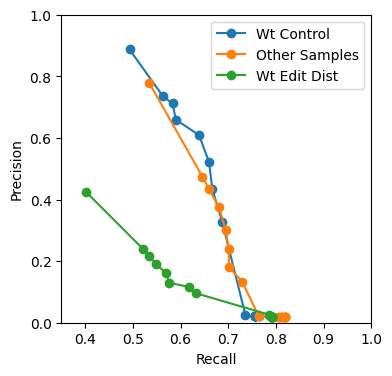

In [24]:
def plot_precision_recall_curve(mutated_df, min_log_likelihoods, min_counts, expected_mutations, min_frequency = 0.01, min_ratio=0.3, save=False, filename='precision_recall_curve.png'):
    """
    Plot precision-recall curve for different likelihood columns.
    Parameters:
    - min_log_likelihoods: List of minimum log likelihoods to consider.
    - min_counts: List of minimum counts to consider.
    - expected_mutations: DataFrame containing expected mutations.
    Returns:
    - None
    """
    fig,ax = plt.subplots(figsize=(4,4))
    all_results_df = pd.DataFrame()
    for likelihood_column in ['signed_log_likelihood_given_wt_control', 'signed_log_likelihood_given_other_samples', 'signed_log_likelihood_given_wt_edit_dist']:
        precisions = []
        recalls = []

        for min_ll in min_log_likelihoods:
            for min_count in min_counts:
                temp_features = []
                for sample in mutated_df['sample'].unique():
                    temp = get_feature_set(
                        mutated_df, sample,
                        likelihood_column= likelihood_column,
                        min_log_likelihood=min_ll,
                        min_count = min_count, min_frequency = min_frequency, min_ratio=min_ratio
                    )
                    temp_features.append(temp)
                features_df = pd.concat(temp_features, ignore_index=True)
                precision_i, recall_i = quantify_found_mutations(features_df, expected_mutations, print_result=False)
                precisions.append(precision_i)
                recalls.append(recall_i)
        ax.plot(recalls, precisions, marker='o', label = likelihood_column.replace('signed_log_likelihood_given_', '').replace('_', ' ').title())
        # Store results in a DataFrame for this likelihood_column
        results_df = pd.DataFrame({
            'min_log_likelihood': np.repeat(min_log_likelihoods, len(min_counts)),
            'min_count': np.tile(min_counts, len(min_log_likelihoods)),
            'precision': precisions,
            'recall': recalls,
        })
        results_df['likelihood_column'] = likelihood_column
        all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)

        ax.legend()
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.grid(False)
        ax.set_xlim(0.35,1)
        ax.set_ylim(0,1)
        if save:
            plt.savefig(filename, bbox_inches='tight', dpi=300)

    return all_results_df

min_log_likelihoods = [-200, -60,-50,-40,-30,-20,-15,-10,0,30,60,90,120,150,180,210,240,270,300]
min_counts = [0]
all_results_df_vary_ll = plot_precision_recall_curve(
    mutated_df, min_log_likelihoods, min_counts, expected_mutations, min_frequency=0, save=True, filename='figures/precision_recall_curve_vary_ll_no_thresholds.png'
)

In [25]:
all_results_df_vary_ll.loc[all_results_df_vary_ll['min_log_likelihood'] == -10]

,min_log_likelihood,min_count,precision,recall,likelihood_column
7,-10,0,0.326733,0.687500,signed_log_likelihood_given_wt_control
26,-10,0,0.133418,0.729167,signed_log_likelihood_given_other_samples
45,-10,0,0.095890,0.631944,signed_log_likelihood_given_wt_edit_dist


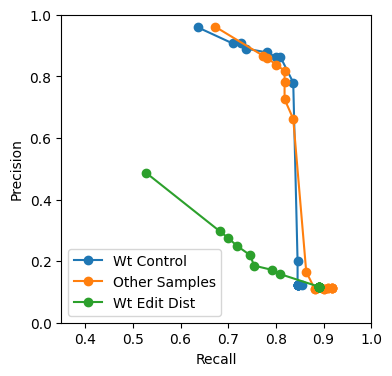

In [26]:
min_log_likelihoods = [-200,-60,-50,-40,-30,-20,-15,-10,0,30,60,90,120,150,180,210,240,270,300]
min_counts = [10]

included_mutations = mutated_df_above_count_freq.loc[(mutated_df_above_count_freq['expected_frequency_from_bulk'].notna()),['sample','HGVSc']]

# Subset expected_mutations to only those included in included_mutations (matching sample and name/HGVSc)
expected_mutations_subset = expected_mutations.merge(
    included_mutations.rename(columns={'HGVSc': 'name'}), 
    on=['sample', 'name']
)

all_results_df_vary_ll = plot_precision_recall_curve(
    mutated_df_above_count_freq, min_log_likelihoods, min_counts, expected_mutations_subset, save=True, filename='figures/precision_recall_curve_vary_ll_default_thresholds.png'
)

### use -10 for expected mutations, -200 for unexpected

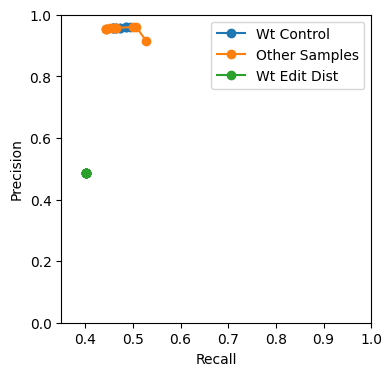

In [27]:
min_log_likelihoods = [-200]
min_counts = np.linspace(0, 100, 10)
all_results_df_vary_counts = plot_precision_recall_curve(
    mutated_df, min_log_likelihoods, min_counts, expected_mutations
)

In [28]:
min_count = 0
min_freq = 0
prior = 200
min_log_likelihood = -prior - 10 ### to keep a likelihood of -10 on expected mutations; -210 on unexpected


temp_mutated_df = mutated_df.copy()

### add a prior on expected mutations
for col in ['signed_log_likelihood_given_wt_control', 'signed_log_likelihood_given_other_samples', 'signed_log_likelihood_given_wt_edit_dist']:
    temp_mutated_df.loc[(temp_mutated_df['expected_frequency_from_bulk'].notna()) & (temp_mutated_df[col].notna()), col] -= prior


### tiered approach to define final set
feature_sets = {}
for sample in mutated_df['sample'].unique():
    temp = get_feature_set(temp_mutated_df, sample, likelihood_column = 'signed_log_likelihood_given_wt_control', min_log_likelihood=min_log_likelihood, min_count=min_count, min_frequency=min_freq)
    temp['origin'] = 'from_control'
    feature_set = temp.copy()
    temp = get_feature_set(temp_mutated_df.loc[temp_mutated_df['signed_log_likelihood_given_wt_control'].isna()], sample, likelihood_column = 'signed_log_likelihood_given_other_samples', min_log_likelihood=min_log_likelihood, min_count=min_count, min_frequency=min_freq)
    temp['origin'] = 'from_others'
    feature_set = pd.concat([feature_set, temp], ignore_index=True)
    temp = get_feature_set(temp_mutated_df.loc[(temp_mutated_df['signed_log_likelihood_given_wt_control'].isna()) & (temp_mutated_df['signed_log_likelihood_given_other_samples'].isna())], sample, likelihood_column = 'signed_log_likelihood_given_wt_edit_dist', min_log_likelihood=min_log_likelihood, min_count=min_count, min_frequency=min_freq)
    temp['origin'] = 'from_edit_dist'
    feature_set = pd.concat([feature_set, temp], ignore_index=True)
    feature_sets[sample] = feature_set

all_feature_sets = pd.concat(feature_sets.values(), ignore_index=True)

for col in ['signed_log_likelihood_given_wt_control', 'signed_log_likelihood_given_other_samples', 'signed_log_likelihood_given_wt_edit_dist']:
    all_feature_sets.loc[all_feature_sets['expected_frequency_from_bulk'].notna(), col] += prior

### make feature set to save using frequency and count thresholds only for the mutations that were not expected
all_features_to_save = all_feature_sets.loc[(all_feature_sets['expected_frequency_from_bulk'].notna()) | ((all_feature_sets['count_of_this_gapfill'] > 10) & (all_feature_sets['frequency'] > 0.01))]

### assess how we did using expected mutations as ground truth
print('Quantifying found mutations against expected mutations:')
print('from all, including below 10 counts and 0.01 frequency:')
quantify_found_mutations(all_feature_sets, expected_mutations)
print('from set to save, above 10 counts and 0.01 frequency:')
quantify_found_mutations(all_features_to_save, expected_mutations)
print('from control:')
quantify_found_mutations(all_features_to_save.loc[all_features_to_save['origin'] == 'from_control'], expected_mutations)
print('from others:')
quantify_found_mutations(all_features_to_save.loc[all_features_to_save['origin'] == 'from_others'], expected_mutations)
print('from edit dist:')
quantify_found_mutations(all_features_to_save.loc[all_features_to_save['origin'] == 'from_edit_dist'], expected_mutations)

### add a sensitivity/specificity here and then use tiered approach to define final set

print(len(all_features_to_save))

Quantifying found mutations against expected mutations:
from all, including below 10 counts and 0.01 frequency:
Fraction of found mutations that were expected (precision): 0.928
Fraction of expected mutations that were found (recall/sensitivity): 0.8055555555555556
from set to save, above 10 counts and 0.01 frequency:
Fraction of found mutations that were expected (precision): 0.9666666666666667
Fraction of expected mutations that were found (recall/sensitivity): 0.8055555555555556
from control:
Fraction of found mutations that were expected (precision): 0.9705882352941176
Fraction of expected mutations that were found (recall/sensitivity): 0.6875
from others:
Fraction of found mutations that were expected (precision): 0.9411764705882353
Fraction of expected mutations that were found (recall/sensitivity): 0.1111111111111111
from edit dist:
Fraction of found mutations that were expected (precision): 1.0
Fraction of expected mutations that were found (recall/sensitivity): 0.0069444444444

In [29]:
all_features_to_save.loc[(all_features_to_save['expected_frequency_from_bulk'].isna())]

### these are included despite very stringent thresholds; likely 3 are unexpected mutations; TET2 c.2906_2908insAA_novel is a way of identifying the dupA mutation despite high error

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
41,ASXL1 c.4183C>G,ASXL1 c.4183C>G,CCACT,CCAGT,0.078534,NaN,AAGGGCATCCCTTCCAAGTGACCCA,TCCAGGGGACTATGCCCAGTAGCTT,360.0,-300.0,-300.000000,-75.457902,BC003_1,2.472125e-03,ASXL1 c.4183C>G,from_control
42,IDH2 c.419G>A,IDH2 c.419G>A,CTGGAT,CCGGAT,0.014170,NaN,GGAAGACAGTCCCCCCCAGGATGTT,AGTTCCATTGGGACTTTTCCACATC,488.0,-300.0,1.305302,-63.334027,BC003_1,2.472125e-03,IDH2 c.419G>A,from_control
71,TET2 c.2908dupA,TET2 c.2906_2908insAA_novel,GTTTT,GTT,0.338092,NaN,GTGCATCTGACTATGGCAAGACTCA,TGGGGTTGCTGTGTTTGCTGCTGTT,2889.0,-300.0,-300.000000,-300.000000,BC004_2,1.615473e-08,TET2 c.2908dupA,from_control
118,TET2 c.3532G>A,TET2 c.3532G>A_novel,TCTTTTA,TCTTTCA,0.401747,NaN,TGCCTTCTTTACCAGTATAGATGAC,ATCCTAATAGCTTTACCCTTCTGTC,184.0,NaN,-300.000000,-50.436407,BC004_4plex,2.472125e-03,TET2 c.3532G>A,from_others


In [30]:
all_features_to_save.to_csv('feature_set_all.csv', index=False)

In [37]:
if 'origin' in mutated_df.columns:
    mutated_df = mutated_df.drop(columns=['origin'])

merge_on = ['HGVSc',
 'gapfill',
 'gapfill_from_transcriptome',
 'lhs_probe',
 'rhs_probe',
 'sample','expected_frequency_from_bulk','likelihood_given_wt_edit_dist']
mutated_df = mutated_df.merge(all_feature_sets[merge_on + ['origin']], on = merge_on, how='left')
mutated_df['in_feature_set'] = mutated_df['origin'].notna()

In [38]:
mutated_df.dropna(subset='expected_frequency_from_bulk')['in_feature_set'].value_counts()

in_feature_set
True     116
False     27
Name: count, dtype: int64

/data1/lareauc/users/blattms/miniconda3/envs/gapfill_utilities/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


SignificanceResult(statistic=0.8439314843666402, pvalue=5.791221565090845e-40)


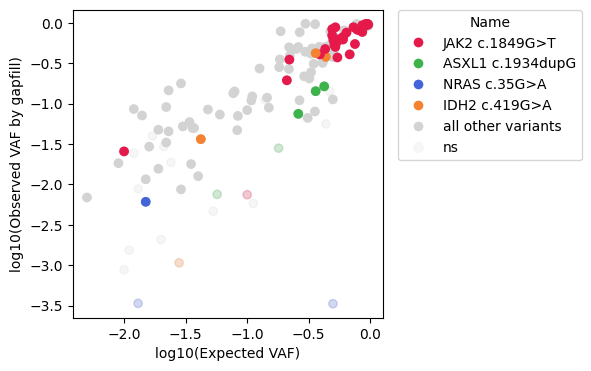

In [39]:
# Use a list of hex color codes for random selection
hex_colors = [
    "#e6194b", "#3cb44b", "#4363d8", "#f58231", "#911eb4", "#46f0f0",
    "#f032e6", "#bcf60c", "#fabebe", "#008080", "#e6beff", "#9a6324", "#fffac8",
    "#800000", "#aaffc3", "#808000", "#ffd8b1", "#000075", "#808080", "#ffffff", "#000000",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#9c9ede", "#6b6ecf", "#b5cf6b", "#cedb9c",
    "#8ca252", "#bd9e39", "#e7ba52", "#e7969c", "#ad494a", "#a55194", "#ce6dbd", "#de9ed6", "#6b6ecf", "#9c9ede",
    "#e6550d", "#fd8d3c", "#fdae6b", "#31a354", "#74c476", "#a1d99b", "#756bb1", "#9e9ac8", "#bcbddc", "#636363",
    "#969696", "#bdbdbd", "#d9d9d9", "#393b79", "#5254a3", "#6b6ecf", "#9c9ede", "#637939", "#8ca252", "#b5cf6b",
    "#cedb9c", "#8c6d31", "#bd9e39", "#e7ba52", "#e7969c", "#843c39", "#ad494a", "#d6616b", "#e7969c", "#7b4173",
    "#a55194", "#ce6dbd", "#de9ed6", "#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6550d", "#fd8d3c", "#fdae6b",
    "#fdd0a2", "#31a354", "#74c476", "#a1d99b", "#c7e9c0", "#756bb1", "#9e9ac8", "#bcbddc", "#dadaeb", "#636363",
    "#969696", "#bdbdbd", "#d9d9d9", "#393b79", "#5254a3", "#6b6ecf", "#9c9ede", "#637939", "#8ca252", "#b5cf6b",
    "#cedb9c", "#8c6d31", "#bd9e39", "#e7ba52", "#e7969c", "#843c39", "#ad494a", "#d6616b", "#e7969c", "#7b4173",
    "#a55194", "#ce6dbd", "#de9ed6", "#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6550d", "#fd8d3c", "#fdae6b",
    "#fdd0a2", "#31a354", "#74c476", "#a1d99b", "#c7e9c0", "#756bb1", "#9e9ac8", "#bcbddc", "#dadaeb", "#636363",
    "#969696", "#bdbdbd", "#d9d9d9"
]

## plot frequency vs expected

import random
random.seed(2)  # For reproducibility

fig,ax = plt.subplots(figsize=(4,4))
df = mutated_df[['sample','HGVSc','frequency','expected_frequency_from_bulk']].dropna().drop_duplicates()

# Only include variants in legend that appear more than twice
variant_counts = df['HGVSc'].value_counts()
variants_to_show = variant_counts[variant_counts > 2].index

x = df['expected_frequency_from_bulk']
y = df['frequency']
import matplotlib.colors as mcolors

# Assign a random color to each unique HGVSc
unique_names = df['HGVSc'].unique()
# Map variants_to_show to hex_colors, all others to grey
color_map = {name: 'lightgrey' for name in unique_names}
for name, color in zip(variants_to_show, hex_colors):
    color_map[name] = color
colors = df['HGVSc'].map(color_map)
alpha_key = mutated_df.dropna(subset='expected_frequency_from_bulk')['in_feature_set'].map({True: 1, False: 0.2})

# Plot all variants in light grey as background
ax.scatter(np.log10(x), np.log10(y), c='lightgrey', alpha=alpha_key)

# Plot variants_to_show on top with assigned colors and alpha
mask = df['HGVSc'].isin(variants_to_show)
ax.scatter(np.log10(x[mask]), np.log10(y[mask]), c=colors[mask], alpha=alpha_key[mask])


# Create a legend mapping colors to names
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=name,
               markerfacecolor=color_map[name], markersize=8)
    for name in variants_to_show
]
# Add a lightgrey marker for "all other variants"
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', label='all other variants',
               markerfacecolor='lightgrey', markersize=8)
)

# Add a lightgrey marker for "all other variants"
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', label='ns',
               markerfacecolor='lightgrey', alpha=0.2, markersize=8)
)
ax.legend(handles=handles, title="Name", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('log10(Expected VAF)')
ax.set_ylabel('log10(Observed VAF by gapfill)')

print(st.spearmanr(x, y))

plt.savefig('figures/gapfill_frequency_vs_expected_frequency.png', bbox_inches='tight', dpi=300)

In [40]:
mutated_df.loc[mutated_df['name'] == 'NRAS c.35G>A'][['lhs_probe','rhs_probe']].drop_duplicates()


,lhs_probe,rhs_probe
16,TTGTCAGTGCGCTTTTCCCAACACC,GCTCCAACCACCACCAGTTTGTACT


In [41]:
mutated_df.loc[(mutated_df['name'] == 'NRAS c.35G>A') & (mutated_df['HGVSc'] == 'NRAS c.35G>A')][['HGVSc','frequency','sample']].sort_values('frequency', ascending=False)

,HGVSc,frequency,sample
19369,NRAS c.35G>A,0.006103,BC011_1
4563,NRAS c.35G>A,0.003174,BC007_1
27888,NRAS c.35G>A,0.000535,BC008_2
36834,NRAS c.35G>A,0.000520,BC014_2
16354,NRAS c.35G>A,0.000476,BC001_1
1875,NRAS c.35G>A,0.000440,BC010_1
13696,NRAS c.35G>A,0.000425,BC013_1
7166,NRAS c.35G>A,0.000407,BC004_1
258,NRAS c.35G>A,0.000400,BC012_1
24677,NRAS c.35G>A,0.000376,BC004_2


In [42]:
df.loc[df['HGVSc'] == 'NRAS c.35G>A']

,sample,HGVSc,frequency,expected_frequency_from_bulk
4563,BC007_1,NRAS c.35G>A,0.003174,0.000
19369,BC011_1,NRAS c.35G>A,0.006103,0.015
20758,BC005_2,NRAS c.35G>A,0.000334,0.497
22263,BC016_2,NRAS c.35G>A,0.000338,0.013


In [43]:
found_mutations = df[['sample','HGVSc']].drop_duplicates()
found_mutations = found_mutations.merge(expected_mutations.drop(['HGVSc'],axis=1).rename(columns={'name':'HGVSc'}), on = ['sample','HGVSc'], how='right', indicator=True)

found_mutations.loc[found_mutations['_merge'] == 'right_only'].sort_values('expected_frequency_from_bulk')

,sample,HGVSc,expected_frequency_from_bulk,gene,_merge
103,BC014_2,NFE2 c.115-1G>A,0.18,NFE2,right_only


In [44]:
found_mutations.loc[found_mutations['HGVSc'] == 'TP53 c.920-1G>A']

,sample,HGVSc,expected_frequency_from_bulk,gene,_merge
10,BC007_1,TP53 c.920-1G>A,0.187,TP53,both


In [45]:
merged_long.loc[(merged_long['HGVSc'] == 'TP53 c.920-1G>A') & (merged_long['sample'] == 'BC007_1')][['name','HGVSc','gapfill','count_of_this_gapfill']]

,name,HGVSc,gapfill,count_of_this_gapfill
5933,TP53 c.920-1G>A,TP53 c.920-1G>A,GTT,78.0


In [46]:
merged_long.loc[(merged_long['name'] == 'TP53 c.919_920') & (merged_long['sample'] == 'BC007_1')][['name','HGVSc','gapfill','count_of_this_gapfill']]

,name,HGVSc,gapfill,count_of_this_gapfill
4473,TP53 c.919_920,TP53 c.919_920del_novel,,14.0
4483,TP53 c.919_920,TP53 c.919_920delinsT_novel,A,1.0
4531,TP53 c.919_920,TP53 c.920C>T_novel,AC,97.0
4950,TP53 c.919_920,TP53 c.920del_novel,C,143.0
5030,TP53 c.919_920,TP53 c.920C>G_novel,CC,4.0
5608,TP53 c.919_920,TP53 c.919del_novel,G,2.0
5613,TP53 c.919_920,TP53 c.919G>T_novel,GA,3.0
5697,TP53 c.919_920,TP53 wildtype,GC,29695.0
5733,TP53 c.919_920,TP53 c.919_920insA_novel,GCT,3.0
5748,TP53 c.919_920,TP53 c.919G>C_novel,GG,2.0


In [47]:
all_features_to_save.loc[(all_features_to_save['HGVSc'].str.contains('\+', na=False)) | (all_features_to_save['HGVSc'].str.contains('\-', na=False))]

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
12,TP53 c.920-1G>A,TP53 c.920-1G>A,GTT,GCT,0.787879,0.187,AGAGGAGCTGGTGTTGTTGGGCAGT,AGGAAAGAGGCAAGGAAAGGTGATA,78.0,-21.019869,-68.803997,NaN,BC007_1,NaN,TP53 c.920-1G>A,from_control
40,TET2 c.4537+2T>G,TET2 c.4537+3A>T,TAACC,TTACC,0.178182,0.029,CACATTTATCTACAAATGCTTTACATTAAAT,TGCCAACTGTTTAGCCTGGCTTGCG,49.0,-13.595516,-72.472580,NaN,BC003_1,NaN,TET2 c.4537+2T>G,from_control
67,TET2 c.4537+2T>G,TET2 c.4537+2T>G,TTCCC,TTACC,0.767442,0.267,CACATTTATCTACAAATGCTTTACATTAAAT,TGCCAACTGTTTAGCCTGGCTTGCG,33.0,-42.305539,-163.163356,NaN,BC010_2,NaN,TET2 c.4537+2T>G,from_control


In [48]:
expected_mutations.loc[expected_mutations['sample'] == 'BC002_1']

,sample,name,expected_frequency_from_bulk,HGVSc,gene
49,BC002_1,ASXL1 c.1249C>T,0.145,c.1249C>T,ASXL1
50,BC002_1,SRSF2 c.161C>T,0.036,c.161C>T,SRSF2
51,BC002_1,TP53 c.376-2A>G,0.076,c.376-2A>G,TP53
52,BC002_1,JAK2 c.1849G>T,0.490,c.1849G>T,JAK2
53,BC002_1,SH2B3 c.894G>A,0.083,c.894G>A,SH2B3
54,BC002_1,TP53 c.535C>T,0.012,c.535C>T,TP53


In [49]:
n_known_mutations = len(all_expected_mutations)
n_mutations_detected = found_mutations['_merge'].value_counts(normalize=False)['both']
n_mutations_not_detected = found_mutations['_merge'].value_counts(normalize=False)['right_only'] ### this was actually a probe not included [NFE2 c.115-1G>A]
n_mutations_significant = mutated_df.dropna(subset='expected_frequency_from_bulk')['in_feature_set'].value_counts()[True]
n_splice_variants = len(all_expected_mutations.loc[all_expected_mutations['name'].str.contains(r'\+|\-')])

print(f"Number of known mutations: {n_known_mutations}")
print(f"Number not targeted: {3}") ## TP53 c.721T>C, ASXL1 c.1900_1922del not targeted, NFE2 c.115-1G>A not targeted in that panel (because of another NFE2 mutation)
print(f"Number of mutations detected: {n_mutations_detected}")
print(f"Number of mutations not detected: {0}")
print(f"Number of mutations with significant gapfill: {n_mutations_significant}")


Number of known mutations: 146
Number not targeted: 3
Number of mutations detected: 143
Number of mutations not detected: 0
Number of mutations with significant gapfill: 116


In [50]:
found_mutations.loc[found_mutations['_merge'] == 'right_only']

,sample,HGVSc,expected_frequency_from_bulk,gene,_merge
103,BC014_2,NFE2 c.115-1G>A,0.18,NFE2,right_only


In [51]:
all_feature_sets.loc[(all_feature_sets['frequency']> 0.01) & (all_feature_sets['count_of_this_gapfill'] > 10) & (all_feature_sets['expected_frequency_from_bulk'].notna())]

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
0,JAK2 c.1849G>T,JAK2 c.1849G>T,AAC,CAC,0.961213,0.910,TGAACCAGAATATTCTCGTCTCCACAGA,ATACTCCATAATTTAAAACCAAATGCTTGTGAGAAAGCTTGCTC,13729.0,-300.000000,-300.000000,-300.000000,BC012_1,0.002472,JAK2 c.1849G>T,from_control
1,JAK2 c.3187_3189,JAK2 c.3188G>A,TATGC,TACGC,0.916342,0.956,TGTCCTTGTTTGTCATTGCCAATCA,ATAAATTCCGCTGGTGGACTTTTAC,4228.0,-300.000000,-300.000000,-300.000000,BC012_1,0.002472,JAK2 c.3187_3189,from_control
2,ASXL1 c.2245_2246insGG,ASXL1 c.2246_2247insGG,GGGGACCGT,GGGGAGT,0.312078,0.347,ATGGCTGGTCCCCAGTGGGAGCAAC,TGGGAGGCATCTCCTAGCCCATCTG,1341.0,-300.000000,-300.000000,NaN,BC012_1,NaN,ASXL1 c.2245_2246insGG,from_control
3,JAK2 c.839C>T,JAK2 c.839C>T,TAAA,TGAA,0.033054,0.022,TAATGGTTGCAAAAATCTCCTCACC,GGACCACTTCCAGGTTCTTTTACTT,71.0,NaN,-51.775434,-13.486597,BC012_1,0.002472,JAK2 c.839C>T,from_others
4,TP53 c.321C>G,TP53 c.321C>G,CCT,CGT,0.952424,0.972,GAATGCAAGAAGCCCAGACGGAAAC,AGCTGCCCTGGTAGGTTTTCTGGGA,4224.0,-300.000000,-300.000000,-300.000000,BC010_1,0.002472,TP53 c.321C>G,from_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,JAK2 c.1849G>T,JAK2 c.1849G>T,AAC,CAC,0.407711,0.390,TGAACCAGAATATTCTCGTCTCCACAGA,ATACTCCATAATTTAAAACCAAATGCTTGTGAGAAAGCTTGCTC,8100.0,-300.000000,300.000000,-300.000000,BC002_4plex,0.002472,JAK2 c.1849G>T,from_control
121,ASXL1 c.1934dupG,ASXL1 c.1934dupG,CCCC,CCC,0.142857,0.360,ATCGGTGGCCCCGCCGCCACCTCCACCCGGGCCA,CCCCCTCCGATGGCAGTGGTGGCC,17.0,-30.117784,-30.699148,-4.298300,BC002_4plex,0.005235,ASXL1 c.1934dupG,from_control
122,U2AF1 c.470A>G,U2AF1 c.470A>G,CTCATACC,CTCATACT,0.319808,0.410,AGCCGCCTCGTGTGCATTCTCCCAT,GACGGCAGCAGGCTTCTCTGAAGTC,15559.0,NaN,-300.000000,-300.000000,BC002_4plex,0.002472,U2AF1 c.470A>G,from_others
123,JAK2 c.1849G>T,JAK2 c.1849G>T,AAC,CAC,0.504348,0.520,TGAACCAGAATATTCTCGTCTCCACAGA,ATACTCCATAATTTAAAACCAAATGCTTGTGAGAAAGCTTGCTC,5104.0,-300.000000,128.908515,-300.000000,BC001_4plex,0.002472,JAK2 c.1849G>T,from_control


SignificanceResult(statistic=0.3335501829831906, pvalue=0.08908387064272233)


/data1/lareauc/users/blattms/miniconda3/envs/gapfill_utilities/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


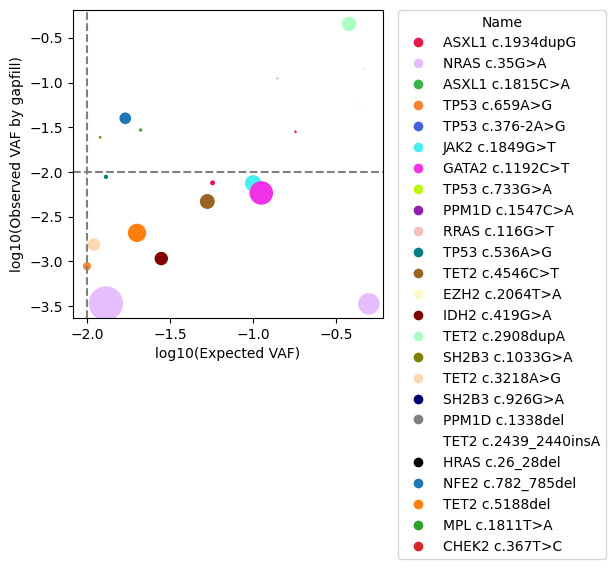

In [52]:
fig,ax = plt.subplots(figsize=(4,4))
df = mutated_df[['sample','HGVSc','frequency','expected_frequency_from_bulk','in_feature_set','count_of_this_probe','count_of_this_gapfill']].dropna().drop_duplicates()
df = df.loc[df['in_feature_set'] == False]

x = df['expected_frequency_from_bulk']
y = df['frequency']

# Assign a random color to each unique HGVSc
unique_names = df['HGVSc'].unique()

color_map = {name: color for name, color in zip(unique_names, hex_colors)}
colors = df['HGVSc'].map(color_map)
alpha_key = df.dropna(subset='expected_frequency_from_bulk')['in_feature_set'].map({True: 1, False: 1})
# Vary the size of the dots by log10(count_of_this_probe)
sizes = df['count_of_this_probe'] / 100# scale for visibility
scatter = ax.scatter(np.log10(x), np.log10(y), c=colors, alpha=alpha_key, s=sizes)

# Create a legend mapping colors to names
handles = [plt.Line2D([0], [0], marker='o', color='w', label=name,
                      markerfacecolor=color_map[name], markersize=8)
           for name in unique_names]
# Only include variants that appear more than twice
variant_counts = df['HGVSc'].value_counts()
variants_to_show = variant_counts[variant_counts > 0].index

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=name,
               markerfacecolor=color_map[name], markersize=8)
    for name in variants_to_show
]
ax.legend(handles=handles, title="Name", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('log10(Expected VAF)')
ax.set_ylabel('log10(Observed VAF by gapfill)')
ax.axvline(np.log10(0.01), color='grey', linestyle='--', label='0.01 VAF threshold')
ax.axhline(np.log10(0.01), color='grey', linestyle='--', label='0.01 VAF threshold')
print(st.spearmanr(x, y))



In [53]:
df.sort_values('expected_frequency_from_bulk', ascending=False).head(20)

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set,count_of_this_probe,count_of_this_gapfill
20758,BC005_2,NRAS c.35G>A,0.000334,0.497,False,20938.0,7.0
14434,BC013_1,RRAS c.116G>T,0.142857,0.467,False,7.0,1.0
23606,BC016_2,EZH2 c.2064T>A,0.056338,0.436,False,71.0,4.0
25300,BC004_2,TET2 c.2908dupA,0.453130,0.378,False,8545.0,3872.0
40793,BC004_4plex,MPL c.1811T>A,0.000000,0.342,False,15.0,0.0
43762,BC001_4plex,ASXL1 c.1934dupG,0.028169,0.180,False,71.0,2.0
30920,BC002_2,PPM1D c.1338del,0.111111,0.140,False,9.0,1.0
10269,BC005_1,GATA2 c.1192C>T,0.005820,0.112,False,25431.0,148.0
11085,BC005_1,TP53 c.733G>A,0.000000,0.109,False,292.0,0.0
10144,BC005_1,JAK2 c.1849G>T,0.007477,0.100,False,11368.0,85.0


In [54]:
expected_mutations['sample'].value_counts().mean()

4.114285714285714

In [55]:
merged_long.groupby('sample')['lhs_probe'].nunique().mean()

64.64864864864865

In [56]:
manifest = pd.read_csv('/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/probe_lists/manifest_BC002.tsv', sep='\t')

In [57]:
manifest.loc[manifest['name'].str.contains('c.')]['lhs_probe'].nunique()

66

In [58]:
expected_mutations.loc[expected_mutations['sample'] == 'BC007_1']

,sample,name,expected_frequency_from_bulk,HGVSc,gene
10,BC007_1,TP53 c.920-1G>A,0.187,c.920-1G>A,TP53
11,BC007_1,CALR c.1150_1154delinsTGTC,0.613,c.1150_1154delinsTGTC,CALR
12,BC007_1,TP53 c.818G>A,0.473,c.818G>A,TP53
13,BC007_1,EZH2 c.2054G>A,0.182,c.2054G>A,EZH2
14,BC007_1,ZRSR2 c.883C>T,0.108,c.883C>T,ZRSR2
15,BC007_1,TP53 c.659A>G,0.010,c.659A>G,TP53
144,BC007_1,NRAS c.35G>A,0.000,c.35G>A,NRAS


In [59]:
all_features_to_save.loc[all_features_to_save['sample'] == 'BC005_1']

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
31,SRSF2 c.284_307del,SRSF2 c.284_307del,CGGC,CGGCGGCTGTGGTGTGAGTCCGGGGGGC,0.977273,0.297,CCCGTACCTGCGGGGTGGCGGTCCC,GGCCGTAGCGCGCCATTTGCACCCG,215.0,-18.805631,-43.690752,NaN,BC005_1,NaN,SRSF2 c.284_307del,from_control
32,TP53 c.527G>A,TP53 c.527G>A,GTA,GCA,0.965203,0.356,TATCTGAGCAGCGCTCATGGTGGGG,GCGCCTCACAACCTCCGTCATGTGC,2968.0,NaN,-300.000000,-300.0,BC005_1,0.002472,TP53 c.527G>A,from_others
33,IDH2 c.418C>T,IDH2 c.418C>T,CAGAT,CGGAT,0.475061,0.250,GAAGACAGTCCCCCCCAGGATGTTC,AGTTCCATTGGGACTTTTCCACATC,44212.0,NaN,-300.000000,-300.0,BC005_1,0.002472,IDH2 c.418C>T,from_others


In [60]:
all_features_to_save.loc[all_features_to_save['sample'] == 'BC004_2']

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
69,MPL c.1771T>G,MPL c.1771T>G,TCGT,TAGT,0.969714,0.771,CAGGCAAGAAGGCTGCAATCTTCGG,CCATCTGGGCCTGGGAGGAACACAG,7012.0,-300.0000,-300.000000,-300.000000,BC004_2,2.472125e-03,MPL c.1771T>G,from_control
70,PTPN11 c.1508G>A,PTPN11 c.1508G>A,TCTC,TCCC,0.438859,0.296,CGGTACTGTGCTTCTGTCTGGACCA,TGACCTCTGAGACCGCACCATCTGG,2200.0,-300.0000,-300.000000,-300.000000,BC004_2,2.472125e-03,PTPN11 c.1508G>A,from_control
71,TET2 c.2908dupA,TET2 c.2906_2908insAA_novel,GTTTT,GTT,0.338092,NaN,GTGCATCTGACTATGGCAAGACTCA,TGGGGTTGCTGTGTTTGCTGCTGTT,2889.0,-300.0000,-300.000000,-300.000000,BC004_2,1.615473e-08,TET2 c.2908dupA,from_control
72,IDH1 c.395G>A,IDH1 c.394C>T,ACAA,ACGA,0.134615,0.077,CTCTGTATTGATCCCCATAAGCATG,CCTATGATGATAGGTTTTACCCATC,70.0,-300.0000,-300.000000,-16.471356,BC004_2,2.472125e-03,IDH1 c.395G>A,from_control
73,RUNX1 c.1103dupC,RUNX1 c.1103dupC,CGGGGCC,CGGGCC,0.070638,0.084,GGTAGGAGGGCGAGCTGGCTTGGAA,TCCCTGCGCTTGCGACGAGCCGGGG,1136.0,-300.0000,-300.000000,-257.203036,BC004_2,1.319162e-05,RUNX1 c.1103dupC,from_control
74,JAK2 c.1849G>T,JAK2 c.1849G>T,AAC,CAC,0.025680,0.010,TGAACCAGAATATTCTCGTCTCCACAGA,ATACTCCATAATTTAAAACCAAATGCTTGTGAGAAAGCTTGCTC,102.0,-22.6551,300.000000,-17.783798,BC004_2,2.472153e-03,JAK2 c.1849G>T,from_control
75,SRSF2 c.284C>G,SRSF2 c.284C>A,GGGTG,GGGGG,0.397917,0.399,TCCCCGGCGGCTGTGGTGTGAGTCC,GCGGCCGTAGCGCGCCATTTGCACC,191.0,NaN,-213.944566,-52.182809,BC004_2,2.472173e-03,SRSF2 c.284C>G,from_others


In [61]:
merged_long.loc[(merged_long['sample'] == 'BC001_1') & (merged_long['name'] == 'CALR c.1154_1155insTTGTC')][['HGVSc','gapfill','frequency','count_of_this_probe']].sort_values('frequency', ascending=False)

,HGVSc,gapfill,frequency,count_of_this_probe
17516,CALR wildtype,CCTT,0.722579,132027.0
17387,CALR c.1155_1156insTTGTC,CCGACAATT,0.245162,132027.0
17657,CALR c.1156del_novel,CTT,0.007385,132027.0
17926,CALR c.1154_1156del_novel,T,0.004166,132027.0
17537,CALR c.1153_1155delinsC_novel,CG,0.003196,132027.0
...,...,...,...,...
18106,CALR c.1153_1156delinsGAAGATGAAGATGAAGAAGAA_novel,TTCTTCTTCATCTTCATCTTC,0.000008,132027.0
18127,CALR c.1153_1156delinsTTGCTAGGACCGCCTAAAGTCTTA...,TTTGACGCGGTTAGCACGTAAGACTTTAGGCGGTCCTAGCAA,0.000008,132027.0
17461,CALR c.1157_1158insAGGATGATGAGGACAAAGATGAGGTTG...,CCTCAACCTCATCTTTGTCCTCATCATCCTCCTT,0.000008,132027.0
17462,CALR c.1157_1158insAGGATGATGAGGACAAAGATGAGGGTG...,CCTCACCCTCATCTTTGTCCTCATCATCCTCCTT,0.000008,132027.0


SignificanceResult(statistic=0.8439314843666402, pvalue=5.791221565090845e-40)


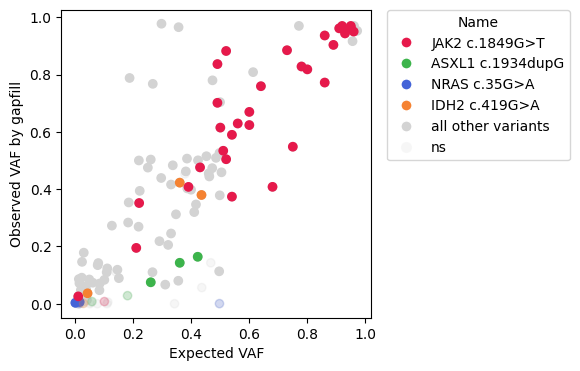

In [62]:
## plot frequency vs expected

import random
random.seed(2)  # For reproducibility

fig,ax = plt.subplots(figsize=(4,4))
df = mutated_df[['sample','HGVSc','frequency','expected_frequency_from_bulk','in_feature_set']].dropna().drop_duplicates()
x = df['expected_frequency_from_bulk']
y = df['frequency']
import matplotlib.colors as mcolors

# Assign a random color to each unique HGVSc
unique_names = df['HGVSc'].unique()

# Only include variants that appear more than twice in color in legend
variant_counts = df['HGVSc'].value_counts()
variants_to_show = variant_counts[variant_counts > 2].index

color_map = {name: 'lightgrey' for name in unique_names}
for name, color in zip(variants_to_show, hex_colors):
    color_map[name] = color
colors = df['HGVSc'].map(color_map)
alpha_key = mutated_df.dropna(subset='expected_frequency_from_bulk')['in_feature_set'].map({True: 1, False: 0.2})

# Plot all variants in light grey as background
ax.scatter(x, y, c='lightgrey', alpha=alpha_key)

# Plot variants_to_show on top with assigned colors and alpha
mask = df['HGVSc'].isin(variants_to_show)
ax.scatter(x[mask], y[mask], c=colors[mask], alpha=alpha_key[mask])

# Create a legend mapping colors to names
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=name,
               markerfacecolor=color_map[name], markersize=8)
    for name in variants_to_show
]
# Add a lightgrey marker for "all other variants"
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', label='all other variants',
               markerfacecolor='lightgrey', markersize=8)
)

# Add a lightgrey marker for "all other variants"
handles.append(
    plt.Line2D([0], [0], marker='o', color='w', label='ns',
               markerfacecolor='lightgrey', alpha=0.2, markersize=8)
)

ax.legend(handles=handles, title="Name", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('Expected VAF')
ax.set_ylabel('Observed VAF by gapfill')

print(st.spearmanr(x, y))

plt.savefig('figures/gapfill_frequency_vs_expected_frequency_linear.png', bbox_inches='tight', dpi=300)


In [63]:
df.loc[x[(x<0.4) & (y>0.8)].index]

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set
10767,BC005_1,SRSF2 c.284_307del,0.977273,0.297,True
11200,BC005_1,TP53 c.527G>A,0.965203,0.356,True


In [64]:
expected_mutations.loc[expected_mutations['sample'] == 'BC005_1']

,sample,name,expected_frequency_from_bulk,HGVSc,gene
55,BC005_1,TP53 c.527G>A,0.356,c.527G>A,TP53
56,BC005_1,IDH2 c.418C>T,0.250,c.418C>T,IDH2
57,BC005_1,SRSF2 c.284_307del,0.297,c.284_307del,SRSF2
58,BC005_1,GATA2 c.1192C>T,0.112,c.1192C>T,GATA2
59,BC005_1,JAK2 c.1849G>T,0.100,c.1849G>T,JAK2
60,BC005_1,TP53 c.733G>A,0.109,c.733G>A,TP53


In [65]:
all_features_to_save.loc[all_features_to_save['sample'] == 'BC005_1']

,name,HGVSc,gapfill,gapfill_from_transcriptome,frequency,expected_frequency_from_bulk,lhs_probe,rhs_probe,count_of_this_gapfill,signed_log_likelihood_given_wt_control,signed_log_likelihood_given_other_samples,signed_log_likelihood_given_wt_edit_dist,sample,likelihood_given_wt_edit_dist,original_name,origin
31,SRSF2 c.284_307del,SRSF2 c.284_307del,CGGC,CGGCGGCTGTGGTGTGAGTCCGGGGGGC,0.977273,0.297,CCCGTACCTGCGGGGTGGCGGTCCC,GGCCGTAGCGCGCCATTTGCACCCG,215.0,-18.805631,-43.690752,NaN,BC005_1,NaN,SRSF2 c.284_307del,from_control
32,TP53 c.527G>A,TP53 c.527G>A,GTA,GCA,0.965203,0.356,TATCTGAGCAGCGCTCATGGTGGGG,GCGCCTCACAACCTCCGTCATGTGC,2968.0,NaN,-300.000000,-300.0,BC005_1,0.002472,TP53 c.527G>A,from_others
33,IDH2 c.418C>T,IDH2 c.418C>T,CAGAT,CGGAT,0.475061,0.250,GAAGACAGTCCCCCCCAGGATGTTC,AGTTCCATTGGGACTTTTCCACATC,44212.0,NaN,-300.000000,-300.0,BC005_1,0.002472,IDH2 c.418C>T,from_others


In [66]:
df.loc[df['sample'] == 'BC005_1']

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set
10144,BC005_1,JAK2 c.1849G>T,0.007477,0.100,False
10269,BC005_1,GATA2 c.1192C>T,0.005820,0.112,False
10420,BC005_1,IDH2 c.418C>T,0.475061,0.250,True
10767,BC005_1,SRSF2 c.284_307del,0.977273,0.297,True
11085,BC005_1,TP53 c.733G>A,0.000000,0.109,False
11200,BC005_1,TP53 c.527G>A,0.965203,0.356,True


In [67]:
df.loc[df['sample'] == 'BC001_1']

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set
16238,BC001_1,PPM1D c.1639del,0.123288,0.110,True
16259,BC001_1,TP53 c.536A>G,0.008811,0.013,False
16345,BC001_1,PPM1D c.1636dup,0.146119,0.023,True
16451,BC001_1,TP53 c.742C>T,0.052342,0.030,True
16539,BC001_1,CALR c.1155_1156insTTGTC,0.245162,0.330,True
17142,BC001_1,SETD2 c.4702A>G,0.393894,0.222,True


In [68]:
merged_long.loc[(merged_long['sample'] == 'BC001_1') & (merged_long['original_name'] == 'PPM1D c.1636_1639')].sort_values('frequency',ascending=False)[['HGVSc','frequency','count_of_this_gapfill','original_name']]

,HGVSc,frequency,count_of_this_gapfill,original_name
17183,PPM1D wildtype,0.712329,156.0,PPM1D c.1636_1639
17184,PPM1D c.1636dup,0.146119,32.0,PPM1D c.1636_1639
17071,PPM1D c.1639del,0.123288,27.0,PPM1D c.1636_1639
17143,PPM1D c.1638_1640del_novel,0.004566,1.0,PPM1D c.1636_1639
17081,PPM1D c.1639A>G_novel,0.004566,1.0,PPM1D c.1636_1639
17189,PPM1D c.1636_1637del_novel,0.004566,1.0,PPM1D c.1636_1639
17988,PPM1D c.1640del_novel,0.004566,1.0,PPM1D c.1636_1639


In [69]:
df.loc[df['HGVSc'] == 'ASXL1 c.1934dupG'].sort_values('frequency',ascending=False)

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set
22547,BC016_2,ASXL1 c.1934dupG,0.163873,0.422,True
41703,BC002_4plex,ASXL1 c.1934dupG,0.142857,0.360,True
38619,BC003_4plex,ASXL1 c.1934dupG,0.074866,0.260,True
43762,BC001_4plex,ASXL1 c.1934dupG,0.028169,0.180,False
468,BC012_1,ASXL1 c.1934dupG,0.007553,0.057,False


In [70]:
df.loc[(df['sample'] == 'BC016_2')]

,sample,HGVSc,frequency,expected_frequency_from_bulk,in_feature_set
21972,BC016_2,JAK2 c.1849G>T,0.964177,0.950,True
22263,BC016_2,NRAS c.35G>A,0.000338,0.013,False
22547,BC016_2,ASXL1 c.1934dupG,0.163873,0.422,True
23606,BC016_2,EZH2 c.2064T>A,0.056338,0.436,False
